In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
# Dataset contains 100,000 reviews
# 25,000 labelled positive or negative
# 25,000 held out for testing
# 50,000 are unlabelled
path = Path("data/")
path.ls()

[PosixPath('data/tmp_clas'),
 PosixPath('data/unsup'),
 PosixPath('data/test'),
 PosixPath('data/README'),
 PosixPath('data/train'),
 PosixPath('data/imdb.vocab'),
 PosixPath('data/models'),
 PosixPath('data/tmp_lm')]

In [4]:
(path/'train').ls()

[PosixPath('data/train/labeledBow.feat'),
 PosixPath('data/train/pos'),
 PosixPath('data/train/neg'),
 PosixPath('data/train/unsupBow.feat')]

In [5]:
# this data follows the imagenet structure where folders indicate labels
# the `unsup` directory contains unlabelled instances
batch_size=32

# this will automatically label data based on folder structure
# tokenize the data, truncated to 100 unique tokens
    # this does things like seperating contractions
    # cleaning content of any HTML or unique symbols
    # replacing unknown tokens with xx
data = (
    TextList.from_folder(path)
    # input all text files
    .filter_by_folder(include=['train', 'test', 'unsup'])
    # randomly split 10% of reviews for validation
    .random_split_by_pct(0.1)
    # label it for a language model
    .label_for_lm()
    .databunch(bs=batch_size)
)

In [6]:
data.show_batch()

idx,text
0,"the tenderness and sensitivity of those who are themselves forced to hide to their feelings and identity . xxmaj in addition to the film , the sound track is very good and pleases in spite of not being very well - known . xxmaj although film is short , it is excellent . xxmaj the time that lasts maintains to us in expectation and the end is unexpected . xxbos"
1,"the movie like me . xxmaj rani xxmaj mukherjee is much more beautiful in the xxmaj chalte xxmaj chalte , yet gives a more charming performance here ( looks are n't everything ) . xxmaj her husky voice works very well for her fight scenes . xxmaj vivek xxmaj oberoi is also good . xxmaj he is n't the lover boy type though i have to give him credit for"
2,"you look close enough ) . xxmaj whether you 've seen it in the theaters or not , it 's probably one of the true enjoyable movies to watch on a weekend afternoon with nothing to do . xxbos xxmaj this is a classic , one of my favourite television series of all time and surely one of the best sitcoms ever . xxmaj mary xxmaj tyler xxmaj moore is"
3,"today , throwing the xxup tv out the hotel room window ) , but just rock in general . \n \n xxmaj contrary to what xxmaj jagger said in a recent interview about one of the reasons he clashed with xxmaj frank , that there was n't enough live music footage , there 's a good plenty of live performances , if maybe not as many as some fans"
4,"xxmaj over the xxmaj river and xxmaj through the xxmaj woods to xxmaj grandmother 's xxmaj house xxmaj we xxmaj go . xxmaj charlie say that the only problem with that song is that his xxmaj grandma lives in a condominium . \n \n xxmaj overall , this is a great special . \n \n 8 / 10 xxbos xxmaj this has to be one of the worst"


In [7]:
# the databunch factory method also numericalizes the data
# converts tokens into a list of integers for all words used
# only keeps words that appear at least twice
# vocabulary is limited to 60,000 words by default
data.vocab.itos[500:530]

['fine',
 'town',
 'genre',
 'flick',
 'run',
 'heart',
 'wants',
 'side',
 'quality',
 'act',
 'horrible',
 'today',
 'city',
 'kill',
 'example',
 'past',
 'close',
 'writing',
 'child',
 'tries',
 'matter',
 'hand',
 'etc',
 'viewer',
 'amazing',
 'turns',
 'parts',
 '\x96',
 'enjoyed',
 'expect']

In [8]:
# can also inspect what the tokenized text represents
data.train_ds[0][0]

Text xxbos xxmaj love him or hate him , you have to admit that xxmaj john xxmaj milius has returned in force to make this wonderfully epic movie . xxmaj he only made two other films ( barely ) worthy of note : the underrated xxmaj flight xxmaj of xxmaj the xxmaj intruder and the equally under - rated xxmaj farewell xxmaj to xxmaj the xxmaj king . xxmaj though directed for television , xxmaj rough xxmaj riders has all the qualities of a great war epic from the sixties . 
 
  xxmaj what helps xxmaj milius is his love of the subject matter . xxmaj with xxmaj the xxmaj wind xxmaj and xxmaj the xxmaj lion , xxmaj rough xxmaj riders feels as though xxmaj milius has a deep and abiding love for xxmaj theodore xxmaj roosevelt . xxmaj every frame of this movie gives you the feeling that xxmaj milius is working from the heart . xxmaj his passion and respect for his subject matter xxunk the greatest performance of xxmaj tom xxmaj berenger 's career . 
 
  xxmaj if you liked this , do see xxmaj the

In [9]:
# but this data is represented as integers for the LSTM model
data.train_ds[0][0].data[20:30]

array([1057,   14,  113,   19, 1859, 1631,   29,    9,    4,   39])

In [10]:
# lets initialize our learning model
# this uses the AWD-LSTM model described here: https://arxiv.org/abs/1708.02182
# drop_mult represents dropout percentage to reduce overfitting
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-03


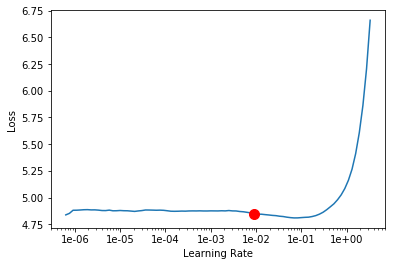

In [11]:
# we can find what the ideal learning rate is for this model:
learn.lr_find()
learn.recorder.plot()

In [12]:
# let's train this encoder using the one cycle policy: https://arxiv.org/abs/1803.09820
# this is only training the final layer
learn.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,4.269607,4.125552,0.284005
2,4.109133,3.997327,0.296537


In [13]:
learn.save('stage-1')

In [14]:
# let's now train the entire network
# note: i'd typically train for atleast 10 epochs here
# but since that'd take ~5 hours, i'll opt instead for just a few epochs
learn.unfreeze()
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,3.864880,3.805120,0.318050
2,3.771770,3.715986,0.329138
3,3.679188,3.687170,0.332825


In [15]:
learn.save('stage-2')

In [17]:
# now that we've trained a simple encoder, we can use it to predict the next words in a movie review
text = "I think this movie was absolutely awful"
words = 50
sentences = 4

print("\n".join(
    learn.predict(text, words, temperature=0.8) for _ in range(sentences)
))

I think this movie was absolutely awful . If you are a Citizen Kane fan , do not pay attention to the plot and plot . The plot motivations were completely implausible and the story was ridiculous . i mean come on , when the bounty hunters believe their black - and -
I think this movie was absolutely awful . i had seen a lot of Mel Brooks movies that i have seen , but this is one of them . i 've seen this movie many times and this is not only for the family but also for the family . The movie has good
I think this movie was absolutely awful . It was just wonderful . It was a movie that is so thought - provoking . 
 
  i would have definitely NEVER watched this movie . i was from Australia . It is one of the worst movies i have ever seen .
I think this movie was absolutely awful . It looks like just ten minutes of Gerard Depardieu , Shirley Temple , David Warner , Starvation , Sir Alan Hale , Jack Nicholson and Maggie Cheung ... all appears to have been


In [18]:
# let's save this encoder to build our text classifer
learn.save_encoder("encoder-5-epochs")

In [7]:
classifier_data = (
    TextList.from_folder(path, vocab=data.vocab)
    .split_by_folder(valid='test')
    .label_from_folder(classes=['neg', 'pos'])
    .databunch(bs=16)
)

In [8]:
classifier_data.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj pier xxmaj paolo xxmaj pasolini , or xxmaj pee - pee - pee as i prefer to call him ( due to his love of showing male genitals ) , is perhaps xxup the most overrated xxmaj european xxmaj marxist director - and they are thick on the ground . xxmaj how anyone can see "" art "" in this messy , cheap sex - romp concoction is",neg
xxbos xxmaj four tales of terror regarding the events at a creepy old mansion are recounted to sceptical xxmaj scotland xxmaj yard investigator xxmaj holloway ( xxmaj john xxmaj bennett ) as he investigates the whereabouts of the latest occupant of the house that dripped blood . \n \n xxmaj one can only struggle to find the words to describe the true brilliance that is the xxmaj house xxmaj,pos
"xxbos xxmaj oftentimes , films of this nature come across as a mixed bag of great work along with slight drivel to fill the runtime . xxmaj whether it be the big name support or the project itself , xxmaj paris je t'aime never falls into this realm . i believe i can truly say that the movie as a whole is better than its parts . xxmaj between the",pos
"xxbos xxmaj they did it . xxmaj and , boy , did they do it fantastically or what ! xxmaj the xxup bbc finally brought the xxmaj doctor back to our screens on a xxmaj saturday evening where he belongs ! xxmaj and they did it with style ! \n \n xxup episode xxup one : "" xxmaj rose "" - xxmaj one of the strengths of the new",pos


In [10]:
# create our text classification model with AWD_LSTM and to load our encoder
learn = text_classifier_learner(classifier_data, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('encoder-5-epochs')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02


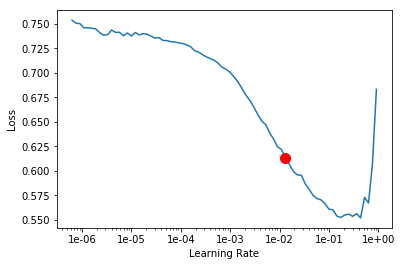

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
# training the last layer
learn.fit_one_cycle(5, 5e-2)

epoch,train_loss,valid_loss,accuracy
1,0.391684,0.271687,0.896480
2,0.392072,0.275567,0.902280
3,0.371133,0.253236,0.900560
4,0.358661,0.225496,0.912360
5,0.348394,0.224054,0.912000


In [25]:
learn.save('classifier-stage-1')

In [26]:
# training the last 2 layers
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(2e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy
1,0.321438,0.257045,0.899800
2,0.261705,0.186547,0.931200
3,0.231998,0.175255,0.935720


In [27]:
learn.save('classifier-stage-2')

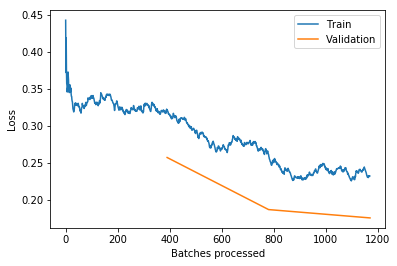

In [28]:
learn.recorder.plot_losses()

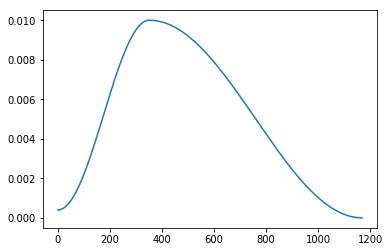

In [29]:
learn.recorder.plot_lr()

In [10]:
# this training was completed in train_classifier.py
# training the last 3 layers
# learn.load('classifier-stage-2-v2')
# learn.freeze_to(-3)
# learn.fit_one_cycle(3, slice(1e-4, 5e-3))
# learn.save('classifier-stage-3-v2')

epoch,train_loss,valid_loss,accuracy
1,0.554110,0.546746,0.746520
2,0.494193,0.460338,0.778320
3,0.466517,0.402174,0.817920


In [10]:
# this training was completed in train.py
# learn.load('classifier-stage-3-v2')
# learn.unfreeze()
# learn.fit_one_cycle(5, slice(2e-5, 1e-3))
# learn.save('classifier-stage-4-v2')

epoch,train_loss,valid_loss,accuracy
1,0.527406,0.450576,0.787080


Traceback (most recent call last):
  File "/home/matt/miniconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/matt/miniconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/matt/miniconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/matt/miniconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/matt/miniconda3/envs/fastai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/matt/miniconda3/envs/fastai/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/matt/miniconda3/envs/fastai/lib/

KeyboardInterrupt: 

In [19]:
learn.load('classifier-stage-4-v2')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj marie : xxmaj you are smooth . xxmaj dan : xxmaj no , i 'm not smooth . i 'm xxmaj dan . 
 
  xxmaj if you 're anything like me , smooth and single do not go together . xxmaj you see someone you like , rare enough as that can be , and you want to say something but you do n't . xxmaj or maybe you do say something but it ends up being perhaps the least intelligent thing you 've ever said in your life . xxmaj more often then not though , you stare from afar and admire without having to deal with taking that which most agree is the only way to get anywhere in life  a risk . xxmaj you ca n't blame a guy for being a little frightened though . xxmaj maybe he 's been burned hard before or maybe he 's trying to focus all his energy on his career . xxmaj there are reasons , some valid , some not , and all of them can be interpreted as excuses rather than reason . xxmaj you tell yourself you do n't need it

In [20]:
learn.predict("I like this movie.")

(Category pos, tensor(1), tensor([2.1590e-05, 9.9998e-01]))

In [24]:
learn.predict("watching this film was like pins in my eyes")

(Category neg, tensor(0), tensor([0.9755, 0.0245]))

In [22]:
learn.predict("This movie sucked")

(Category neg, tensor(0), tensor([0.8881, 0.1119]))

In [26]:
review = """
Suicide Squad was a disappointment to me. May be I got hooked on the hype or was expecting too much from WB. This movie had a great concept that we saw on the small screen, both TV series and animated. For some reason, those formats did it better than this theatrical release. 

This movie suffered from all fronts, poor writing which is the number one problem for me. The story was just all over the place with such in coherency, it's visible at every point. Not enough time was spent in developing these characters for their introduction to the big stage. Poor dialogue was another major problem which is just so stupid at some points. 

But Suicide Squad still could have been saved with the main plot and a great villain. Sadly that too was a major problem. The main plot didn't make sense because the movie itself went in so many directions that none of it could have come together and gel.The villain was a total failure. Nothing about this person was intriguing and just falls so flat. Story and main purpose was so awful for a big summer blockbuster. 

This movie probably only had about two things going for it. Majority of the casting was great including Will Smith, Margot Robbie, Viola Davis, Jared Leto, and Jai Courtney. Yes Jai Courtney, I'm shocked too. I really think his role should have been expanded. Notable miscast would be Joel Kinnaman and Cara Delevingne. Joel Kinnaman portrayal of Rick Flag was out of touch of what that character should be and for Enchantress, someone, more older with more acting depth should have been chosen over Cara Delevingne. 

The other thing would be, through and through it's a much better movie than Batman V Superman. I know that's not really helping but still. A weak six stars and a onetime watch.
"""

# 56% positive review probability
# which is pretty close to the review, which rated Suicide Squad 6/10
learn.predict(review)

(Category pos, tensor(1), tensor([0.4380, 0.5620]))

In [32]:
interp = ClassificationInterpretation.from_learner(learn)

In [33]:
losses, idxs = interp.top_losses()

In [44]:
losses[:10]

tensor([10.7645,  8.9936,  7.5867,  7.5138,  7.3499,  7.2538,  7.2468,  7.1938,
         7.1878,  7.1373])

In [37]:
interp.most_confused(min_val=5)

[('neg', 'pos', 4077), ('pos', 'neg', 1609)]